In [1]:
#making the correlation plot between evrery waveform

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import h5py
import glob 
from scipy import interpolate
import json
import os
import sys
from NuRadioReco.utilities import units
from NuRadioReco.detector import detector
from NuRadioMC.utilities import fluxes
from NuRadioMC.utilities.Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
#from my_Veff import get_Veff_Aeff, get_Veff_Aeff_array, get_index, get_Veff_water_equivalent
from NuRadioMC.examples.Sensitivities import E2_fluxes3 as limits
from Get_hdf5_data import get_attr_data, get_shower_data, get_station_data, get_Veff_data, get_event_data, get_nur_data
from Peak_Finding import count_peak, get_noise, save_data_2_csv, read_column_csv, get_peak, make_max_array
import numpy as np
import matplotlib.pyplot as plt
from NuRadioReco.utilities import units
import NuRadioReco.detector.detector as detector
import NuRadioReco.modules.io.eventReader
import astropy
from NuRadioReco.framework.parameters import stationParameters as stnp
import pandas as pd
from math import isclose
import mplhep as hep
from scipy.signal import find_peaks

temp_stdout = None
# Disable
def blockPrint():
    global temp_stdout
    temp_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    global temp_stdout
    sys.stdout = temp_stdout


PATH = "/home/teikiet/Data/"
##########################################################################
S_ID = [100, 2, 3, 4, 5] #station ID
C_ID = list(range(0,16)) #channel ID
V_pole_channel = list(range(0,8)) #channel ID
H_pole_channel = list(range(8,16)) #channel ID
##########################################################################
E = 18 #energy
detectordescription = "detector/ara2.json" #detector 
##########################################################################
 
# data in csv file:
data_mm = PATH + f'Peak_data/Data_monopoles_ara2_n1.000e03_1e{E}.csv'
data_neu = PATH + f'Peak_data/Data_neutrinos_ara2_n1.000e03_1e{E}.csv'
data_noise = PATH + f'Peak_data/Data_noise_ara2.csv'
##########################################################################


In [3]:
import ROOT 
import numpy as np
import matplotlib.pyplot as plt
import radiotools.helper

def correlation(channel1, channel2):
    return radiotools.helper.get_normalized_xcorr(channel1,channel2)
    
# Open the ROOT file for reading
file = "/home/teikiet/Data/grA_ev1_A4_2018_ie0_4096_T26Mar23-131515.979900_run4402.root"
root_file = ROOT.TFile(file, "READ")

keys = root_file.GetListOfKeys()
# Loop through the keys and identify TGraph objects
G_name = []
for key in keys:
    obj = key.ReadObj()
    if isinstance(obj, ROOT.TGraph):
        graph_name = key.GetName()
        G_name.append(graph_name)
print(G_name)
#Channel info for root file: ############################################################################################################
v_pole_channel_name = ['grCPAvg2M883_0', 'grCPAvgN_M128_0', 'grfftCPAvgN_M128_0', 'grCPAvg2M883_1', 'grCPAvgN_M128_1', 'grfftCPAvgN_M128_1', 'grCPAvg2M883_2', 'grCPAvgN_M128_2', 'grfftCPAvgN_M128_2', 'grCPAvg2M883_3', 'grCPAvgN_M128_3', 'grfftCPAvgN_M128_3', 'grCPAvg2M883_4', 'grCPAvgN_M128_4', 'grfftCPAvgN_M128_4', 'grCPAvg2M883_5', 'grCPAvgN_M128_5', 'grfftCPAvgN_M128_5', 'grCPAvg2M883_6', 'grCPAvgN_M128_6', 'grfftCPAvgN_M128_6', 'grCPAvg2M883_7', 'grCPAvgN_M128_7', 'grfftCPAvgN_M128_7']
h_pole_channel_name = ['grCPAvg2M883_8', 'grCPAvgN_M128_8', 'grfftCPAvgN_M128_8', 'grCPAvg2M883_9', 'grCPAvgN_M128_9', 'grfftCPAvgN_M128_9', 'grCPAvg2M883_10', 'grCPAvgN_M128_10', 'grfftCPAvgN_M128_10', 'grCPAvg2M883_11', 'grCPAvgN_M128_11', 'grfftCPAvgN_M128_11', 'grCPAvg2M883_12', 'grCPAvgN_M128_12', 'grfftCPAvgN_M128_12', 'grCPAvg2M883_13', 'grCPAvgN_M128_13', 'grfftCPAvgN_M128_13', 'grCPAvg2M883_14', 'grCPAvgN_M128_14', 'grfftCPAvgN_M128_14', 'grCPAvg2M883_15', 'grCPAvgN_M128_15', 'grfftCPAvgN_M128_15']

G_name = v_pole_channel_name

def read_root_file(root_file, graph_name):
    root_file = ROOT.TFile(root_file, "READ")
    # Get the TGraph by name
    graph = root_file.Get(graph_name)

    # Check if the TGraph exists
    if graph:
        # Access information about the TGraph
        n_points = graph.GetN()

        # Convert LowLevelViews to Python lists
        x_values = np.frombuffer(graph.GetX(), dtype=np.float64)
        y_values = np.frombuffer(graph.GetY(), dtype=np.float64)
        return int(graph_name[-1]), y_values
    else:
        print("TGraph", graph_name, "not found in the ROOT file.")
# Close the ROOT file when done
root_file.Close()
#######################################################################################################################################
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
#Channel info: #############################################################################################################
v_pole_channel_info = [S_ID, V_pole_channel]
h_pole_channel_info = [S_ID, H_pole_channel]

#Get data:
def get_trigger_event(data, s_ID, c_ID):
    data_frame = pd.read_csv(data)
    event_id = np.array(data_frame["event"])
    num_of_events = int(event_id[-1])
    e_id = list(range(1, int(num_of_events+1)))
    data = []
    noise = 1.0661514487245143e-05
    threshold = 5
    for i in range(len(e_id)):
        for station in s_ID:
            for channel in c_ID:
                trace_i = np.array(data_frame.query(f"station == {station} and channel == {channel} and event == {i}")['Traces']) 
                
                if len(trace_i) == 0:
                    pass
                else:
                    snr_i = abs(trace_i)/noise
                    num_bin = int(len(snr_i)/11) #11 is the bin size
                    snr_i = make_max_array(snr_i, num_bin)
                    peaks, _ = find_peaks(snr_i, height=threshold)
                    num_peak = len(peaks)
                    data_i = []
                    print("num_peak:",num_peak," station:", station," channel:", channel)
                    trace_i = list(trace_i)
                    data_i.append(num_peak)
                    data_i.append(station)
                    data_i.append(channel)
                    data_i.append(trace_i)
                    ##############################
                    data.append(data_i)
    return data
    
#Get trace:

def get_trace_from_data(channel_info):
    trace_neu =  get_trigger_event(data_neu, *channel_info)
    trace_mm =  get_trigger_event(data_mm, *channel_info)
    trace_noise =  get_trigger_event(data_noise, *channel_info)
    return trace_neu, trace_mm, trace_noise

def get_pair_correlation(trace_1, trace_2, peak):
    if trace_1 == trace_2:
        p = [max(correlation(np.array(trace_1[i][3]), np.array(trace_2[j][3])))
                                for i in range(len(trace_1))
                                for j in range(i+1, len(trace_2))
                                if trace_1[i][1] == trace_2[j][1] and trace_1[i][2] == trace_2[j][2] and trace_1[i][0] == peak] #remove duplicate
    elif trace_1 != trace_2 and type(trace_1[0]) != str:
        p = [max(correlation(np.array(trace_1[i][3]), np.array(trace_2[j][3])))
                                for i in range(len(trace_1))
                                for j in range(len(trace_2))
                                if trace_1[i][1] == trace_2[j][1] and trace_1[i][2] == trace_2[j][2] and trace_1[i][0] == peak]
    elif type(trace_1[0]) == str:
        p = [max(correlation(read_root_file(file, trace_1[i])[1], np.array(trace_2[j][3])))
                            for i in range(len(trace_1))
                            for j in range(len(trace_2))
                            if read_root_file(file, trace_1[i])[0] == trace_2[j][2] and trace_2[i][0] == peak]
    p = np.array(p)
    p = p[~np.isnan(p)] #remove nan
    return p

def get_correlation(trace_neu, trace_mm, trace_noise, G_name, peak):
    #neutrino to neutrino
    pairs_correlation_n2n = get_pair_correlation(trace_neu, trace_neu, peak)
    #Monopole to monopole
    pairs_correlation_m2m = get_pair_correlation(trace_mm, trace_mm, peak)
    #Neutrino to monopole
    pairs_correlation_m2n = get_pair_correlation(trace_mm, trace_neu, peak)
    #Cal Pulser to neutrino
    pairs_correlation_c2n = get_pair_correlation(G_name, trace_neu, peak)
    #Cal Pulser to monopole
    pairs_correlation_c2m = get_pair_correlation(G_name, trace_mm, peak)
    #noise to cal pulser:
    pairs_correlation_noise2c = get_pair_correlation(G_name, trace_noise, peak)
    return pairs_correlation_n2n, pairs_correlation_m2m, pairs_correlation_m2n, pairs_correlation_c2n, pairs_correlation_c2m, pairs_correlation_noise2c


['grUBFFTAvg0_2018_439', 'grUBAvg0_2018_439', 'grUBFFTAvg1_2018_892', 'grUBAvg1_2018_892', 'grUBFFTAvg2_2018_439', 'grUBAvg2_2018_439', 'grUBFFTAvg3_2018_892', 'grUBAvg3_2018_892', 'grUBFFTAvg4_2018_892', 'grUBAvg4_2018_892', 'grUBFFTAvg5_2018_892', 'grUBAvg5_2018_892', 'grUBFFTAvg6_2018_892', 'grUBAvg6_2018_892', 'grUBFFTAvg7_2018_892', 'grUBAvg7_2018_892', 'grUBFFTAvg8_2018_439', 'grUBAvg8_2018_439', 'grUBFFTAvg9_2018_439', 'grUBAvg9_2018_439', 'grUBFFTAvg10_2018_439', 'grUBAvg10_2018_439', 'grUBFFTAvg11_2018_892', 'grUBAvg11_2018_892', 'grUBFFTAvg12_2018_439', 'grUBAvg12_2018_439', 'grUBFFTAvg13_2018_439', 'grUBAvg13_2018_439', 'grUBFFTAvg14_2018_439', 'grUBAvg14_2018_439', 'grUBFFTAvg15_2018_892', 'grUBAvg15_2018_892', 'grUBFFTAvg16_2018_892', 'grUBAvg16_2018_892', 'grUBFFTAvg17_2018_892', 'grUBAvg17_2018_892', 'grUBFFTAvg18_2018_892', 'grUBAvg18_2018_892', 'grUBFFTAvg19_2018_892', 'grUBAvg19_2018_892', 'grEvWf', 'grCPAvg2M883_0', 'grCPAvgN_M128_0', 'grfftCPAvgN_M128_0', 'grCPAvg2M

In [4]:
DATA2 = get_trigger_event(data_mm,*v_pole_channel_info)

num_peak: 1  station: 2  channel: 0
num_peak: 1  station: 2  channel: 1
num_peak: 1  station: 2  channel: 2
num_peak: 1  station: 2  channel: 3
num_peak: 1  station: 2  channel: 4
num_peak: 1  station: 2  channel: 5
num_peak: 1  station: 2  channel: 6
num_peak: 1  station: 2  channel: 7
num_peak: 0  station: 5  channel: 0
num_peak: 1  station: 5  channel: 1
num_peak: 1  station: 5  channel: 2
num_peak: 1  station: 5  channel: 3
num_peak: 1  station: 5  channel: 4
num_peak: 1  station: 5  channel: 5
num_peak: 1  station: 5  channel: 6
num_peak: 2  station: 5  channel: 7
num_peak: 2  station: 100  channel: 0
num_peak: 1  station: 100  channel: 1
num_peak: 0  station: 100  channel: 2
num_peak: 1  station: 100  channel: 3
num_peak: 1  station: 100  channel: 4
num_peak: 1  station: 100  channel: 5
num_peak: 1  station: 100  channel: 6
num_peak: 1  station: 100  channel: 7


In [4]:
trace_neu_v, trace_mm_v, trace_noise_v = get_trace_from_data(v_pole_channel_info)
trace_neu_h, trace_mm_h, trace_noise_h = get_trace_from_data(h_pole_channel_info)

num_peak: 1  station: 100  channel: 0
num_peak: 1  station: 100  channel: 1
num_peak: 1  station: 100  channel: 2
num_peak: 1  station: 100  channel: 3
num_peak: 1  station: 100  channel: 4
num_peak: 1  station: 100  channel: 5
num_peak: 1  station: 100  channel: 6
num_peak: 1  station: 100  channel: 7
num_peak: 0  station: 4  channel: 0
num_peak: 0  station: 4  channel: 1
num_peak: 0  station: 4  channel: 2
num_peak: 0  station: 4  channel: 3
num_peak: 1  station: 4  channel: 4
num_peak: 1  station: 4  channel: 5
num_peak: 1  station: 4  channel: 6
num_peak: 1  station: 4  channel: 7
num_peak: 1  station: 3  channel: 0
num_peak: 1  station: 3  channel: 1
num_peak: 1  station: 3  channel: 2
num_peak: 1  station: 3  channel: 3
num_peak: 1  station: 3  channel: 4
num_peak: 1  station: 3  channel: 5
num_peak: 1  station: 3  channel: 6
num_peak: 1  station: 3  channel: 7
num_peak: 0  station: 3  channel: 0
num_peak: 0  station: 3  channel: 1
num_peak: 0  station: 3  channel: 2
num_peak: 0 

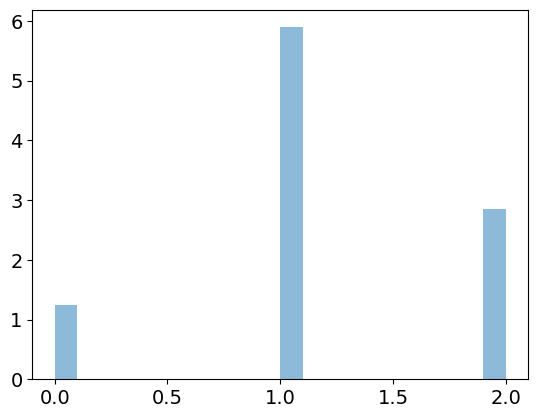

In [5]:
t = trace_mm_v
P = []
for i in range(len(t)):
    P.append(t[i][0])
plt.hist(P, bins=20, density=True, alpha=0.5, label="mm")

t = trace_neu_v
P = []
for i in range(len(t)):
    P.append(t[i][0])
#plt.hist(P, bins=20, density=True, alpha=0.5, label="neu")

In [6]:
#V_pole channel:
import numpy as np
import matplotlib.pyplot as plt

# Data for histograms

def plot_corr(data1, data2, data3, data4, data5, data6, name):
    # Create a figure and set up subplots
    bin_edges = 100
    # Plot the first histogram with log scale on y-axis
    h1 = np.histogram(data1, bins=bin_edges, density=True)

    h2 = np.histogram(data2, bins=bin_edges,  density=True)

    h3 = np.histogram(data3, bins=bin_edges,   density=True)

    h4 = np.histogram(data4, bins=bin_edges,   density=True)

    h5 = np.histogram(data5, bins=bin_edges,   density=True)

    h6 = np.histogram(data6, bins=bin_edges, density=True)
    # Add labels and title to the figure
    #plt.yscale('log')
    # Show the plot
    #plt.figure(figsize=(15, 3))
    #plt.errorbar(h1[1][:-1], h1[0], fmt='-', color='blue', capsize=2, label='neutrinos to neutrinos ')
    #plt.errorbar(h2[1][:-1], h2[0], fmt='-', color='red', capsize=2 , label='monopoles to monopoles')
    plt.errorbar(h3[1][:-1], h3[0], fmt='-', capsize=2 , label=f'monopoles to neutrinos: {name}')
    #plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='green', capsize=2 , label='noise to noise')

    #plt.yscale('symlog')
    #plt.xscale('log')
    plt.grid()  
    plt.legend(loc='upper right')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Density distribution')
    plt.title(f'Density distribution of correlation between waveforms of {name} at E = 1e{E} EeV')
    #plt.show()
"""    plt.figure(figsize=(15, 3))
    plt.errorbar(h4[1][:-1], h4[0], fmt='-', color='blue', capsize=2 , label='Cal Pulser to neutrinos')
    plt.errorbar(h5[1][:-1], h5[0], fmt='-', color='red', capsize=2 , label='Cal Pulser to monopoles')
    plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='black', capsize=2 , label='noise to Cal Pulser')

    plt.yscale('symlog')
    #plt.xscale('log')
    plt.grid()
    plt.legend(loc='upper right')
    plt.xlabel('Correlation coefficient')
    plt.ylabel('Density distribution')
    plt.title(f'Density distribution of correlation between waveforms of {name} at E = 1e{E} EeV')
    plt.show()"""


"    plt.figure(figsize=(15, 3))\n    plt.errorbar(h4[1][:-1], h4[0], fmt='-', color='blue', capsize=2 , label='Cal Pulser to neutrinos')\n    plt.errorbar(h5[1][:-1], h5[0], fmt='-', color='red', capsize=2 , label='Cal Pulser to monopoles')\n    plt.errorbar(h6[1][:-1], h6[0], fmt='--', color='black', capsize=2 , label='noise to Cal Pulser')\n\n    plt.yscale('symlog')\n    #plt.xscale('log')\n    plt.grid()\n    plt.legend(loc='upper right')\n    plt.xlabel('Correlation coefficient')\n    plt.ylabel('Density distribution')\n    plt.title(f'Density distribution of correlation between waveforms of {name} at E = 1e{E} EeV')\n    plt.show()"

/home/teikiet/.local/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/home/teikiet/.local/lib/python3.10/site-packages/radiotools/helper.py:826: RuntimeWarning: invalid value encountered in divide
  return correlate(trace1, trace2, mode=mode, method='auto') / (np.sum(trace1 ** 2) * np.sum(trace2 ** 2)) ** 0.5


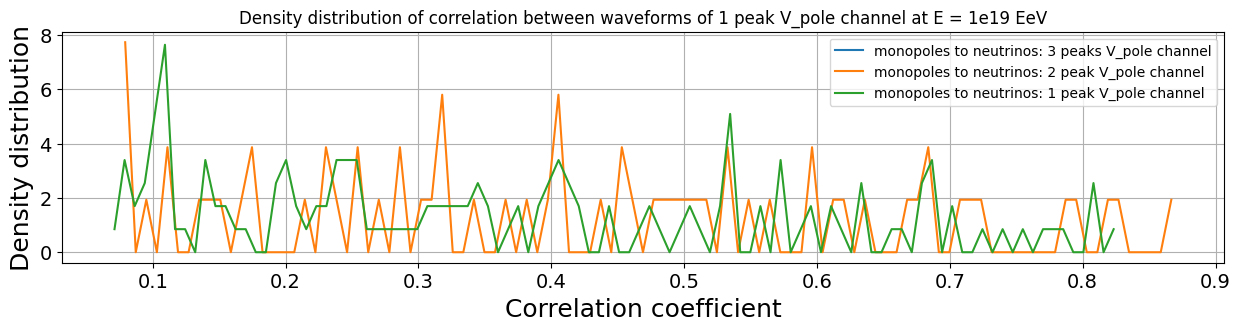

In [7]:
plt.figure(figsize=(15, 3))

data1, data2, data3, data4, data5, data6 = get_correlation(trace_neu_v, trace_mm_v, trace_noise_v, v_pole_channel_name, 3)
plot_corr(data1, data2, data3, data4, data5, data6, "3 peaks V_pole channel")

data1, data2, data3, data4, data5, data6 = get_correlation(trace_neu_v, trace_mm_v, trace_noise_v, v_pole_channel_name, 2)
plot_corr(data1, data2, data3, data4, data5, data6, "2 peak V_pole channel")

data1, data2, data3, data4, data5, data6 = get_correlation(trace_neu_v, trace_mm_v, trace_noise_v, v_pole_channel_name, 1)
plot_corr(data1, data2, data3, data4, data5, data6, "1 peak V_pole channel")

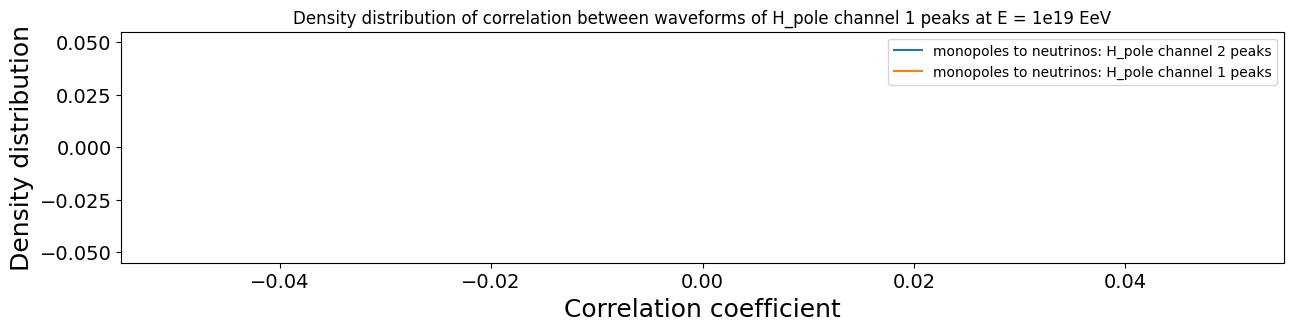

In [8]:
plt.figure(figsize=(15, 3))
data1, data2, data3, data4, data5, data6 = get_correlation(trace_neu_h, trace_mm_h, trace_noise_h, h_pole_channel_name, 2)
plot_corr(data1, data2, data3, data4, data5, data6, "H_pole channel 2 peaks")
data1, data2, data3, data4, data5, data6 = get_correlation(trace_neu_h, trace_mm_h, trace_noise_h, h_pole_channel_name, 1)
plot_corr(data1, data2, data3, data4, data5, data6, "H_pole channel 1 peaks")

In [ ]:
for i in range(len(trace_neu)):
    for j in range(i+1, len(trace_neu)):
        corr = max(correlation(np.array(trace_neu[i]), np.array(trace_neu[j])))
        if  corr > 1:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_neu[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_neu[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            

NameError: name 'trace_neu' is not defined

In [ ]:
for i in range(len(trace_neu)):
    for j in range(len(trace_mm)):
        corr = max(correlation(np.array(trace_neu[i]), np.array(trace_mm[j])))
        if corr >1:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_neu[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_mm[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            

In [ ]:
for i in range(len(trace_mm)):
    for j in range(i+1, len(trace_mm)):
        corr = max(correlation(np.array(trace_mm[i]), np.array(trace_mm[j])))
        if corr >1:
            #make side by side plot
            plt.figure(figsize=(15,2))
            plt.subplot(1,2,1)
            plt.plot(np.array(trace_mm[i]))
            plt.subplot(1,2,2)
            plt.plot(np.array(trace_mm[j]))
            plt.title(f"corr = {corr}")
            plt.show()
            

0.3545766219953519


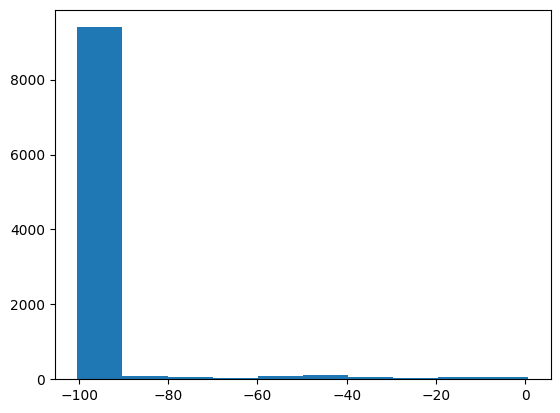